In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    
                                                     
import gym
from gymnasium import spaces

from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

from skimage.transform import resize
import torch
import torch.nn as nn
import torch.nn.functional as F

The below code is my RL extension to https://www.researchgate.net/publication/360698153_A_Tutorial_on_Structural_Optimization 

In [2]:
x0,y0=9,9

In [3]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width = y0, height = x0, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [4]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [5]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [6]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [7]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [8]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [9]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [10]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [11]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [12]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [13]:
class CantileverEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self, normalized_image: bool = False):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
#         DIM=self.args.nelx*self.args.nely
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=0,
                                            high=255,
                                            shape=(self.args.nely, self.args.nelx, 1),
                                            dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        tmp, const = fast_stopt(self.args, self.x)
        
        self.step_+=1
        
        self.reward+=(1/tmp)**2
       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if const>0.65:
#             self.reward-=1
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
                
#         resized_x = resize(self.x, ( self.args.nely, self.args.nelx), anti_aliasing=True)  
#         resized_x = (resized_x * 255).astype(np.uint8).reshape(x0,y0,1)

        return self.x.reshape(x0,y0,1), self.reward, done, False, {}

    def reset(self, seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0
        
#         resized_x = resize(self.x, (self.args.nely, self.args.nelx), anti_aliasing=True)
#         resized_x = (resized_x * 255).astype(np.uint8).reshape(x0,y0,1)

        return self.x.reshape(x0,y0,1), {}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [14]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [15]:
# ts=5e6
ts=9e6

In [16]:
# Create log dir
log_dir = "/tmp/gym7_1_3/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = CantileverEnv()
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)
check_env(env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:30: UserWarning: It seems that your observation  is an image but its `dtype` is (float64) whereas it has to be `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:51: UserWarning: The minimal resolution for an image is 36x36 for the default `CnnPolicy`. You might need to use a custom features extractor cf. https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for 

In [17]:
# callback = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq = 10000, log_dir = log_dir)

In [18]:
start = time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
# model = PPO.load(log_dir + "best_model.zip", env=env).learn(total_timesteps=ts, callback=callback)
end = time.time()   

Num timesteps: 10000
Best mean reward: -inf - Last mean reward per episode: 0.03
Saving new best model to /tmp/gym7_1_3/best_model.zip
Num timesteps: 20000
Best mean reward: 0.03 - Last mean reward per episode: 0.03
Saving new best model to /tmp/gym7_1_3/best_model.zip
Num timesteps: 30000
Best mean reward: 0.03 - Last mean reward per episode: 0.03
Saving new best model to /tmp/gym7_1_3/best_model.zip
Num timesteps: 40000
Best mean reward: 0.03 - Last mean reward per episode: 0.04
Saving new best model to /tmp/gym7_1_3/best_model.zip
Num timesteps: 50000
Best mean reward: 0.04 - Last mean reward per episode: 0.05
Saving new best model to /tmp/gym7_1_3/best_model.zip
Num timesteps: 60000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Saving new best model to /tmp/gym7_1_3/best_model.zip
Num timesteps: 70000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 80000
Best mean reward: 0.05 - Last mean reward per episode: 0.06
Saving new best model to /tm

Num timesteps: 860000
Best mean reward: 0.24 - Last mean reward per episode: 0.20
Num timesteps: 870000
Best mean reward: 0.24 - Last mean reward per episode: 0.18
Num timesteps: 880000
Best mean reward: 0.24 - Last mean reward per episode: 0.17
Num timesteps: 890000
Best mean reward: 0.24 - Last mean reward per episode: 0.17
Num timesteps: 900000
Best mean reward: 0.24 - Last mean reward per episode: 0.16
Num timesteps: 910000
Best mean reward: 0.24 - Last mean reward per episode: 0.16
Num timesteps: 920000
Best mean reward: 0.24 - Last mean reward per episode: 0.15
Num timesteps: 930000
Best mean reward: 0.24 - Last mean reward per episode: 0.16
Num timesteps: 940000
Best mean reward: 0.24 - Last mean reward per episode: 0.15
Num timesteps: 950000
Best mean reward: 0.24 - Last mean reward per episode: 0.15
Num timesteps: 960000
Best mean reward: 0.24 - Last mean reward per episode: 0.15
Num timesteps: 970000
Best mean reward: 0.24 - Last mean reward per episode: 0.15
Num timesteps: 9

Num timesteps: 1850000
Best mean reward: 0.24 - Last mean reward per episode: 0.14
Num timesteps: 1860000
Best mean reward: 0.24 - Last mean reward per episode: 0.15
Num timesteps: 1870000
Best mean reward: 0.24 - Last mean reward per episode: 0.15
Num timesteps: 1880000
Best mean reward: 0.24 - Last mean reward per episode: 0.14
Num timesteps: 1890000
Best mean reward: 0.24 - Last mean reward per episode: 0.16
Num timesteps: 1900000
Best mean reward: 0.24 - Last mean reward per episode: 0.17
Num timesteps: 1910000
Best mean reward: 0.24 - Last mean reward per episode: 0.18
Num timesteps: 1920000
Best mean reward: 0.24 - Last mean reward per episode: 0.18
Num timesteps: 1930000
Best mean reward: 0.24 - Last mean reward per episode: 0.17
Num timesteps: 1940000
Best mean reward: 0.24 - Last mean reward per episode: 0.18
Num timesteps: 1950000
Best mean reward: 0.24 - Last mean reward per episode: 0.17
Num timesteps: 1960000
Best mean reward: 0.24 - Last mean reward per episode: 0.18
Num 

Num timesteps: 2840000
Best mean reward: 0.24 - Last mean reward per episode: 0.17
Num timesteps: 2850000
Best mean reward: 0.24 - Last mean reward per episode: 0.18
Num timesteps: 2860000
Best mean reward: 0.24 - Last mean reward per episode: 0.16
Num timesteps: 2870000
Best mean reward: 0.24 - Last mean reward per episode: 0.15
Num timesteps: 2880000
Best mean reward: 0.24 - Last mean reward per episode: 0.15
Num timesteps: 2890000
Best mean reward: 0.24 - Last mean reward per episode: 0.15
Num timesteps: 2900000
Best mean reward: 0.24 - Last mean reward per episode: 0.14
Num timesteps: 2910000
Best mean reward: 0.24 - Last mean reward per episode: 0.13
Num timesteps: 2920000
Best mean reward: 0.24 - Last mean reward per episode: 0.13
Num timesteps: 2930000
Best mean reward: 0.24 - Last mean reward per episode: 0.13
Num timesteps: 2940000
Best mean reward: 0.24 - Last mean reward per episode: 0.13
Num timesteps: 2950000
Best mean reward: 0.24 - Last mean reward per episode: 0.13
Num 

Num timesteps: 3830000
Best mean reward: 0.24 - Last mean reward per episode: 0.16
Num timesteps: 3840000
Best mean reward: 0.24 - Last mean reward per episode: 0.16
Num timesteps: 3850000
Best mean reward: 0.24 - Last mean reward per episode: 0.16
Num timesteps: 3860000
Best mean reward: 0.24 - Last mean reward per episode: 0.16
Num timesteps: 3870000
Best mean reward: 0.24 - Last mean reward per episode: 0.16
Num timesteps: 3880000
Best mean reward: 0.24 - Last mean reward per episode: 0.16
Num timesteps: 3890000
Best mean reward: 0.24 - Last mean reward per episode: 0.15
Num timesteps: 3900000
Best mean reward: 0.24 - Last mean reward per episode: 0.15
Num timesteps: 3910000
Best mean reward: 0.24 - Last mean reward per episode: 0.14
Num timesteps: 3920000
Best mean reward: 0.24 - Last mean reward per episode: 0.12
Num timesteps: 3930000
Best mean reward: 0.24 - Last mean reward per episode: 0.11
Num timesteps: 3940000
Best mean reward: 0.24 - Last mean reward per episode: 0.11
Num 

Num timesteps: 4820000
Best mean reward: 0.24 - Last mean reward per episode: 0.06
Num timesteps: 4830000
Best mean reward: 0.24 - Last mean reward per episode: 0.06
Num timesteps: 4840000
Best mean reward: 0.24 - Last mean reward per episode: 0.06
Num timesteps: 4850000
Best mean reward: 0.24 - Last mean reward per episode: 0.06
Num timesteps: 4860000
Best mean reward: 0.24 - Last mean reward per episode: 0.06
Num timesteps: 4870000
Best mean reward: 0.24 - Last mean reward per episode: 0.06
Num timesteps: 4880000
Best mean reward: 0.24 - Last mean reward per episode: 0.06
Num timesteps: 4890000
Best mean reward: 0.24 - Last mean reward per episode: 0.07
Num timesteps: 4900000
Best mean reward: 0.24 - Last mean reward per episode: 0.07
Num timesteps: 4910000
Best mean reward: 0.24 - Last mean reward per episode: 0.07
Num timesteps: 4920000
Best mean reward: 0.24 - Last mean reward per episode: 0.07
Num timesteps: 4930000
Best mean reward: 0.24 - Last mean reward per episode: 0.07
Num 

Num timesteps: 5810000
Best mean reward: 0.24 - Last mean reward per episode: 0.14
Num timesteps: 5820000
Best mean reward: 0.24 - Last mean reward per episode: 0.14
Num timesteps: 5830000
Best mean reward: 0.24 - Last mean reward per episode: 0.14
Num timesteps: 5840000
Best mean reward: 0.24 - Last mean reward per episode: 0.14
Num timesteps: 5850000
Best mean reward: 0.24 - Last mean reward per episode: 0.14
Num timesteps: 5860000
Best mean reward: 0.24 - Last mean reward per episode: 0.14
Num timesteps: 5870000
Best mean reward: 0.24 - Last mean reward per episode: 0.16
Num timesteps: 5880000
Best mean reward: 0.24 - Last mean reward per episode: 0.17
Num timesteps: 5890000
Best mean reward: 0.24 - Last mean reward per episode: 0.17
Num timesteps: 5900000
Best mean reward: 0.24 - Last mean reward per episode: 0.16
Num timesteps: 5910000
Best mean reward: 0.24 - Last mean reward per episode: 0.15
Num timesteps: 5920000
Best mean reward: 0.24 - Last mean reward per episode: 0.15
Num 

Num timesteps: 6800000
Best mean reward: 0.24 - Last mean reward per episode: 0.23
Num timesteps: 6810000
Best mean reward: 0.24 - Last mean reward per episode: 0.22
Num timesteps: 6820000
Best mean reward: 0.24 - Last mean reward per episode: 0.21
Num timesteps: 6830000
Best mean reward: 0.24 - Last mean reward per episode: 0.19
Num timesteps: 6840000
Best mean reward: 0.24 - Last mean reward per episode: 0.21
Num timesteps: 6850000
Best mean reward: 0.24 - Last mean reward per episode: 0.20
Num timesteps: 6860000
Best mean reward: 0.24 - Last mean reward per episode: 0.17
Num timesteps: 6870000
Best mean reward: 0.24 - Last mean reward per episode: 0.18
Num timesteps: 6880000
Best mean reward: 0.24 - Last mean reward per episode: 0.20
Num timesteps: 6890000
Best mean reward: 0.24 - Last mean reward per episode: 0.21
Num timesteps: 6900000
Best mean reward: 0.24 - Last mean reward per episode: 0.21
Num timesteps: 6910000
Best mean reward: 0.24 - Last mean reward per episode: 0.21
Num 

Num timesteps: 7790000
Best mean reward: 0.24 - Last mean reward per episode: 0.13
Num timesteps: 7800000
Best mean reward: 0.24 - Last mean reward per episode: 0.13
Num timesteps: 7810000
Best mean reward: 0.24 - Last mean reward per episode: 0.13
Num timesteps: 7820000
Best mean reward: 0.24 - Last mean reward per episode: 0.13
Num timesteps: 7830000
Best mean reward: 0.24 - Last mean reward per episode: 0.13
Num timesteps: 7840000
Best mean reward: 0.24 - Last mean reward per episode: 0.13
Num timesteps: 7850000
Best mean reward: 0.24 - Last mean reward per episode: 0.14
Num timesteps: 7860000
Best mean reward: 0.24 - Last mean reward per episode: 0.13
Num timesteps: 7870000
Best mean reward: 0.24 - Last mean reward per episode: 0.13
Num timesteps: 7880000
Best mean reward: 0.24 - Last mean reward per episode: 0.13
Num timesteps: 7890000
Best mean reward: 0.24 - Last mean reward per episode: 0.14
Num timesteps: 7900000
Best mean reward: 0.24 - Last mean reward per episode: 0.14
Num 

Num timesteps: 8760000
Best mean reward: 0.26 - Last mean reward per episode: 0.13
Num timesteps: 8770000
Best mean reward: 0.26 - Last mean reward per episode: 0.13
Num timesteps: 8780000
Best mean reward: 0.26 - Last mean reward per episode: 0.13
Num timesteps: 8790000
Best mean reward: 0.26 - Last mean reward per episode: 0.13
Num timesteps: 8800000
Best mean reward: 0.26 - Last mean reward per episode: 0.12
Num timesteps: 8810000
Best mean reward: 0.26 - Last mean reward per episode: 0.12
Num timesteps: 8820000
Best mean reward: 0.26 - Last mean reward per episode: 0.12
Num timesteps: 8830000
Best mean reward: 0.26 - Last mean reward per episode: 0.12
Num timesteps: 8840000
Best mean reward: 0.26 - Last mean reward per episode: 0.13
Num timesteps: 8850000
Best mean reward: 0.26 - Last mean reward per episode: 0.12
Num timesteps: 8860000
Best mean reward: 0.26 - Last mean reward per episode: 0.12
Num timesteps: 8870000
Best mean reward: 0.26 - Last mean reward per episode: 0.13
Num 

In [19]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 427.45634628534316 min


### Inference

In [20]:
# env.M.flag_=True
env.M.flag_=False
obs=env.reset()
obs=obs[0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.M to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.M` for environment variables or `env.get_wrapper_attr('M')` that will search the reminding wrappers.
  logger.warn(


In [21]:
i=0
while i<2000:
    action, _states = model.predict(obs)
    obs, rewards, dones, _ , info = env.step(int(action))
    if dones: 
        break
    i+=1

In [22]:
print(i)

81


In [23]:
fast_stopt(env.args, env.x)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.args to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.args` for environment variables or `env.get_wrapper_attr('args')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.x to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.x` for environment variables or `env.get_wrapper_attr('x')` that will search the reminding wrappers.
  logger.warn(


(51580108.58372826, 0.3334000000000001)


Final Cantilever beam design:


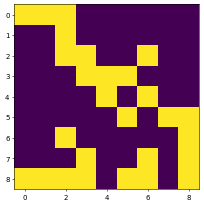

In [24]:
env.render()

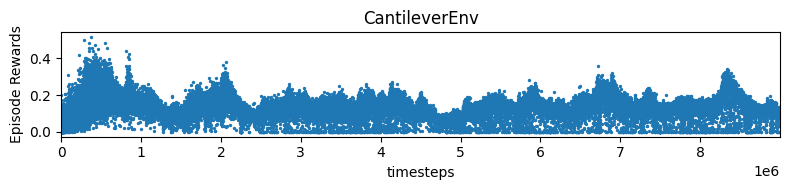

In [25]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [26]:
obs=env.reset()
obs=obs[0]

In [27]:
# Load the agent
model_best = PPO.load(log_dir + "best_model.zip", env=env)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.render_mode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.render_mode` for environment variables or `env.get_wrapper_attr('render_mode')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [28]:
i=0
while i<2000:
    action, _states = model_best.predict(obs)
    
    obs, rewards, dones, _ , info = env.step(int(action))
    if dones:
        break
    i+=1

In [29]:
i

81


Final Cantilever beam design:


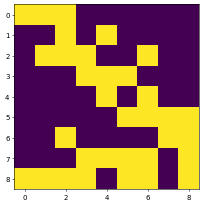

In [30]:
env.render()

In [31]:
# https://stable-baselines3.readthedocs.io/en/master/guide/save_format.html

In [32]:
fast_stopt(env.args, env.x)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.args to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.args` for environment variables or `env.get_wrapper_attr('args')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.x to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.x` for environment variables or `env.get_wrapper_attr('x')` that will search the reminding wrappers.
  logger.warn(


(66.45025051518273, 0.4074666666666667)